In [10]:
import os
import pandas as pd
import seaborn as sns

SEED = 42

In [14]:
def read_solution_file(name, root):
    """Read solution csv to pandas dataframe"""
    dataset = name.split('_')[0]
    key = name.split('_soln')[0]
    n = int(key.split('_')[1])
    columns = ['idx', 'n', 'value']
    columns.extend(list(range(n)))
    columns.append('trailing')
    data = pd.read_csv(os.path.join(root, name), sep=' ', header=None, names=columns)
    data.insert(0, 'dataset', dataset)
    return data

def calculate_rel_error(correct_and_computed):
    """Calculate relative error"""
    correct_value, computed_value = correct_and_computed
    difference = abs(correct_value - computed_value)
    max_value = max(correct_value, computed_value)
    assert(difference == 0 or max_value > 0), f"difference = {difference} and max_value = {max_value}"
    rel_error = difference/max_value if (max_value > 0) else 0
    return rel_error            


In [15]:
correct_df = None

for root, dirs, files in os.walk("../../data", topdown=False):
    for name in files:
        if ("soln" in name): # and (any([k in name for k in ['_0', '_1']])):
            if correct_df is None:
                correct_df = read_solution_file(name, root)
            else:
                correct_df = pd.concat([correct_df, read_solution_file(name, root)])
correct_df = correct_df.drop(['trailing'], axis=1)

computed_df = None

for root, dirs, files in os.walk("../ins_and_outs/outs", topdown=False):
    for name in files:
        if ("soln" in name): # and (any([k in name for k in ['_0', '_1']])):
            if computed_df is None:
                computed_df = read_solution_file(name, root)
            else:
                computed_df = pd.concat([computed_df, read_solution_file(name, root)])
computed_df = computed_df.drop(['trailing'], axis=1)


In [16]:
display(
    'correct_df', correct_df.sample(n=5, random_state=SEED),
    'computed_df', computed_df.sample(n=5, random_state=SEED),
)

'correct_df'

,dataset,idx,n,value,0,1,2,3,4,5,...,30,31,32,33,34,35,36,37,38,39
489,zkc,387,40,39939,1,1,0,1,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
941,zkw,1960,4,3311,1,0,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,zkw,1458,25,4473,0,0,0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,zkc,184,22,17807,1,0,0,1,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,nk,197,40,46263,1,0,1,1,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


'computed_df'

,dataset,idx,n,value,0,1,2,3,4,5,...,30,31,32,33,34,35,36,37,38,39
256,zkw,1738,10,8003,1,1,0,0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,zkc,115,37,26753,1,1,0,1,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN
358,zkc,359,27,24647,0,1,1,1,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,nk,492,32,13765,1,0,1,1,0.0,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,nk,58,27,22339,0,0,1,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Create comparison dataframe, dataset, index, n and values for correct and computed dataframes
columns = ['dataset', 'idx', 'n', 'value']
# Join correct and computed dataframe on 'dataset', 'idx', 'n'
comparison_df = correct_df[columns].merge(computed_df[columns], on=['dataset', 'idx', 'n'])
# Rename correct and cumputed value columns
comparison_df = comparison_df.rename({'value_x': 'correct', 'value_y': 'computed'}, axis=1)
# Compute relative error
comparison_df['rel_error'] = comparison_df[['correct', 'computed']].apply(calculate_rel_error, axis=1)

display(comparison_df.sample(n=5, random_state=SEED))

,dataset,idx,n,correct,computed,rel_error
6489,zkc,387,40,39939,38696,0.031122
13875,zkw,1960,4,3311,3311,0.000000
14408,zkw,1458,25,4473,4473,0.000000
7855,zkc,184,22,17807,17089,0.040321
4696,nk,197,40,46263,45213,0.022696


In [18]:
# Comparison statistics of correct and computed and relative error
comparison_df.describe()

,idx,n,correct,computed,rel_error
count,14651.000000,14651.000000,14651.000000,14651.00000,14651.000000
mean,342.388847,23.450072,20522.807385,19685.83223,0.043019
std,345.161592,11.407734,13060.151349,12717.59789,0.075607
min,1.000000,4.000000,0.000000,0.00000,0.000000
25%,138.000000,15.000000,9190.500000,8665.00000,0.000000
50%,276.000000,25.000000,20979.000000,20079.00000,0.025007
75%,414.000000,32.000000,29751.500000,28565.50000,0.041635
max,2000.000000,40.000000,270389.000000,270389.00000,0.981035


In [19]:
# Group data by 'dataset' and 'n'
aggregated_df = comparison_df[['dataset', 'n', 'rel_error']].groupby(['dataset', 'n']).agg(['mean', 'max'])
# Flatten rows multiindex 
aggregated_df = aggregated_df.reset_index()
# Flatten columns multiindex (keep last level that is not empty)
aggregated_df.columns = [tup[-1] if tup[-1] != '' else tup[0] for tup in aggregated_df.columns.to_flat_index()]
# From 'mean' and 'max' create 'rel_error_type' and 'rel_error'
aggregated_df = pd.melt(aggregated_df, id_vars=['dataset', 'n'], var_name='rel_error_type', value_name='rel_error')

display(aggregated_df.sample(n=5, random_state=42))

,dataset,n,rel_error_type,rel_error
4,nk,22,mean,0.039571
62,zkw,15,max,0.421790
18,zkc,27,mean,0.026444
0,nk,4,mean,0.006945
28,zkw,22,mean,0.052320


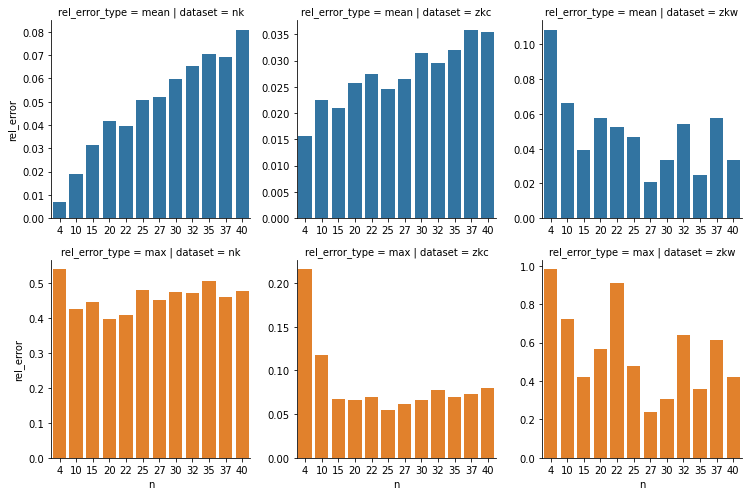

In [20]:
# Create facetgrid datasets in columns, rel_error_type in rows
g = sns.FacetGrid(aggregated_df, col="dataset", row="rel_error_type", hue='rel_error_type', sharey=False, sharex=False, height=3.5) # , hue="score"
# Visualize rel_error as barplot
g.map(sns.barplot, 'n', 'rel_error', order=sorted(aggregated_df['n'].unique()))